### Comprehensive Performance Metrics for BERT Model

In [1]:
import numpy as np
import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [4]:
from utils.functions import set_seed, build_vocab

# Set parameters for BERT model
set_seed(42)
embedding_dim = 768  # BERT hidden size
max_len = 200

# Build vocabulary and load embeddings
word2idx, idx2word = build_vocab(train_df['text'])
pretrained_embeddings = None

In [5]:
# Load the trained BERT model
from transformers import BertTokenizer
from models.bert import SpamBERT
from utils.constants import MODEL_SAVE_PATH
import os
import torch

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = SpamBERT(dropout=0.2)

# Load the trained model weights
model_path = os.path.join(MODEL_SAVE_PATH, 'spam_bert_final.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print(f"Model loaded on: {device}")

Model loaded on: cpu


### Comprehensive Performance Metrics

In [6]:
from utils.functions import encode
from torch.utils.data import TensorDataset, DataLoader

# Prepare test data for BERT
def bert_encode(texts, tokenizer, max_len=200):
    """Tokenize and encode sequences for BERT"""
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, 
                     max_length=max_len, return_tensors='pt')

# Encode test data
test_encodings = bert_encode(test_df['text'], tokenizer, max_len)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Create test dataset and dataloader
test_dataset = TensorDataset(
    test_encodings['input_ids'], 
    test_encodings['attention_mask'], 
    y_test_tensor
)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Test data prepared: {len(test_df)} samples")
print(f"Input shape: {test_encodings['input_ids'].shape}")
print(f"Labels shape: {y_test_tensor.shape}")

Test data prepared: 606 samples
Input shape: torch.Size([606, 200])
Labels shape: torch.Size([606])


In [7]:
# Get model predictions
y_pred_probs_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Get predictions from BERT model
        outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Handle tuple output if necessary
        if isinstance(outputs, tuple):
            probs = outputs[0]
        else:
            probs = outputs
            
        y_pred_probs_list.extend(probs.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_pred_probs = np.array(y_pred_probs_list)
y_true = np.array(y_true_list)
y_pred = (y_pred_probs > 0.5).astype(int)

print(f"Predictions generated:")
print(f"- Probabilities shape: {y_pred_probs.shape}")
print(f"- Predictions shape: {y_pred.shape}")
print(f"- True labels shape: {y_true.shape}")
print(f"- Prediction range: [{y_pred_probs.min():.3f}, {y_pred_probs.max():.3f}]")

Predictions generated:
- Probabilities shape: (606,)
- Predictions shape: (606,)
- True labels shape: (606,)
- Prediction range: [0.041, 0.959]


In [8]:
from metrics.metrics import compute_metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Compute metrics - now returns a DataFrame
metrics_df = compute_metrics(y_true, y_pred, y_pred_probs)
metrics_df

,Value,Description,Optimal
Metric,,,
Accuracy,0.971947,Proportion of correct predictions (TP + TN) / ...,Higher better
Precision,0.948454,Proportion of true positives among predicted p...,Higher better
Recall (Spam Catch Rate),0.963351,Proportion of true positives among actual posi...,Higher better
F1-Score,0.955844,Harmonic mean of precision and recall,Higher better
Specificity (Ham Preservation Rate),0.975904,Proportion of true negatives among actual nega...,Higher better
False Positive Rate,0.024096,Proportion of false positives among actual neg...,Lower better
False Negative Rate,0.036649,Proportion of false negatives among actual pos...,Lower better
AUC-ROC,0.989592,Area under the Receiver Operating Characterist...,Higher better
Youden's J,0.939254,Recall + Specificity - 1,Higher better


In [44]:
metrics_df.attrs['metrics_dict']['auc_roc']

0.9895918753548225

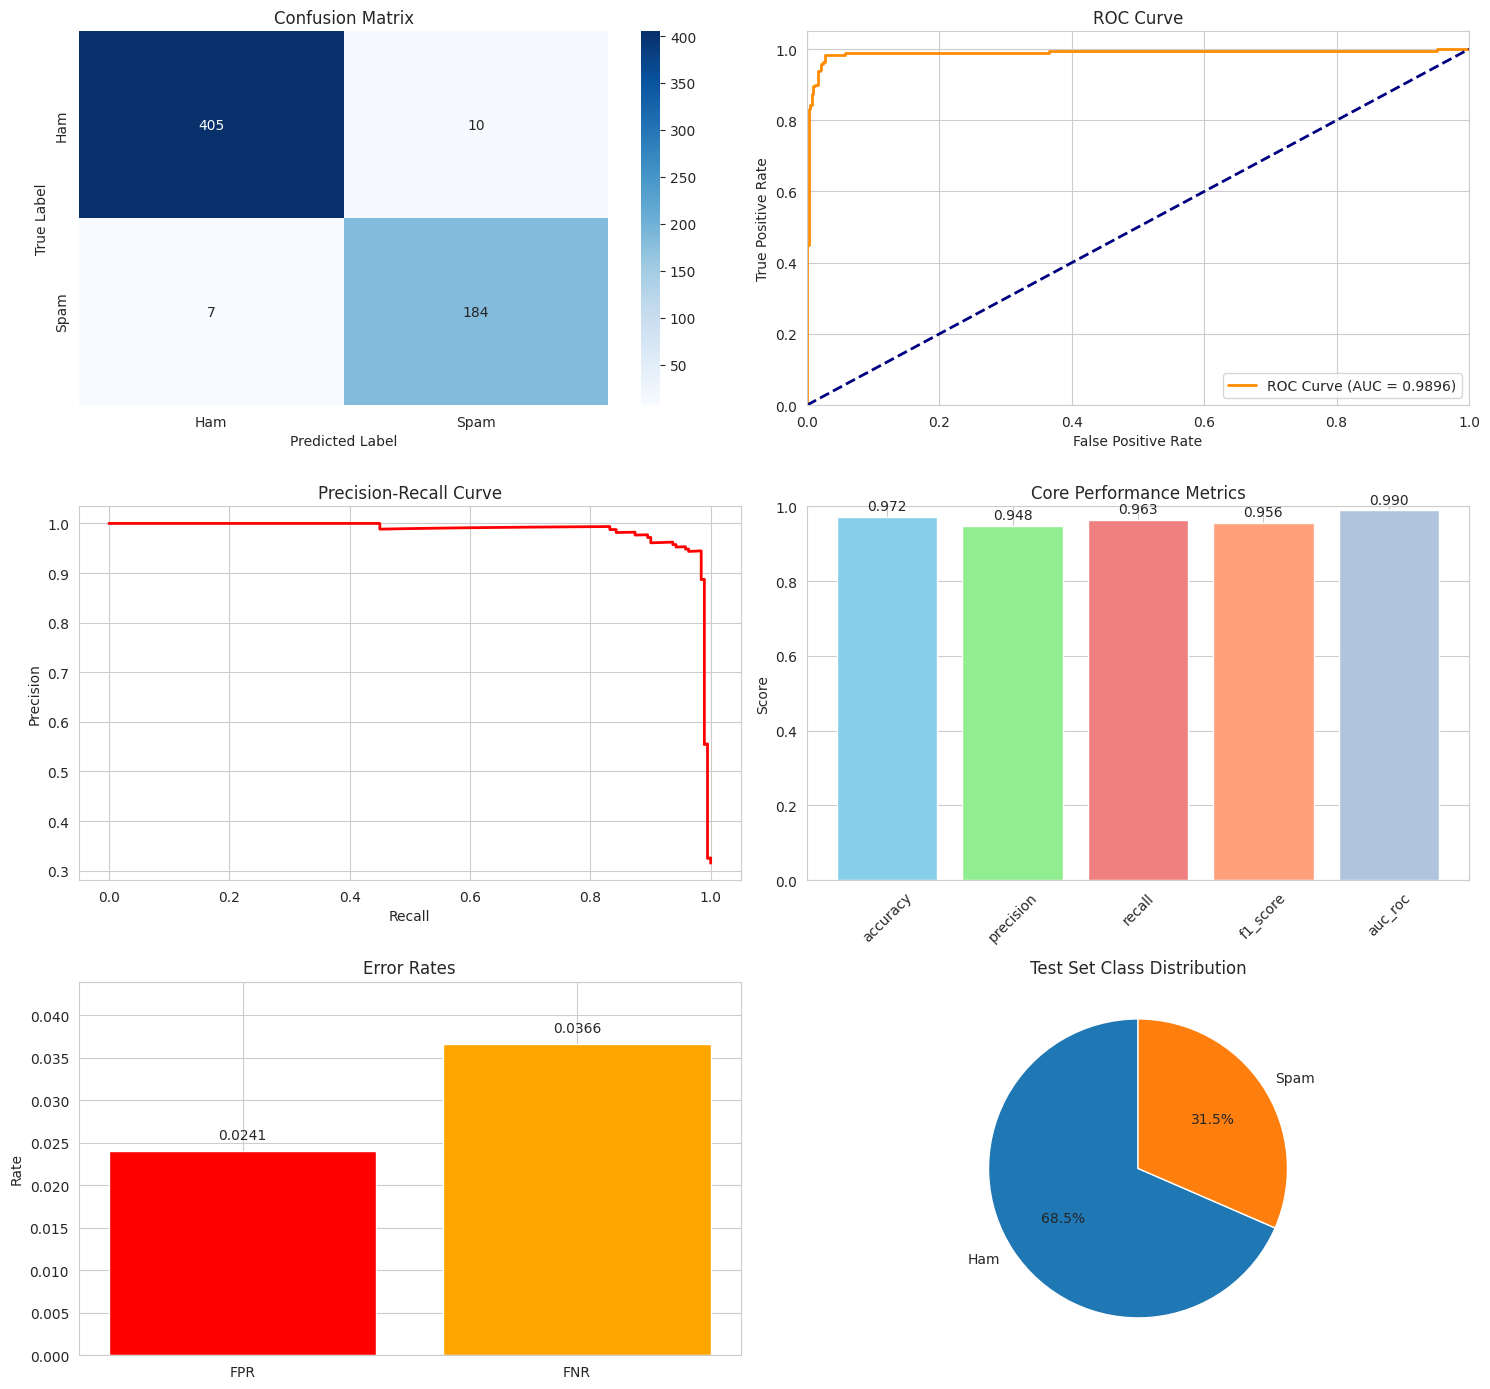

In [55]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

metrics = metrics_df.attrs['metrics_dict']
# Visualizations
plt.figure(figsize=(15, 14))

# 1. Confusion Matrix
plt.subplot(3, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 2. ROC Curve
plt.subplot(3, 2, 2)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {metrics["auc_roc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve
plt.subplot(3, 2, 3)
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall_vals, precision_vals, color='red', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# 4. Core Metrics Bar Chart
plt.subplot(3, 2, 4)
core_metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
core_metric_values = [metrics[name] if name in metrics else metrics['recall']
                     for name in core_metric_names]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightsteelblue']
bars = plt.bar(core_metric_names, core_metric_values, color=colors)
plt.title('Core Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
# Add value labels on bars
for bar, value in zip(bars, core_metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# 5. Error Rates
plt.subplot(3, 2, 5)
error_names = ['FPR', 'FNR']
error_values = [metrics['fpr'], metrics['fnr']]
colors_error = ['red', 'orange']
bars = plt.bar(error_names, error_values, color=colors_error)
plt.title('Error Rates')
plt.ylabel('Rate')
plt.ylim(0, max(error_values) * 1.2)
# Add value labels on bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom')

# 6. Class Distribution
plt.subplot(3, 2, 6)
class_counts = [np.sum(y_true == 0), np.sum(y_true == 1)]
class_names = ['Ham', 'Spam']
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution')

plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Threshold Optimization Analysis
def analyze_thresholds(y_true, y_pred_probs, thresholds=None):
    """Analyze performance across different decision thresholds"""
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.05)
    
    results = []
    for threshold in thresholds:
        y_pred_thresh = (y_pred_probs >= threshold).astype(int)
        
        # Calculate metrics for this threshold
        acc = accuracy_score(y_true, y_pred_thresh)
        prec = precision_score(y_true, y_pred_thresh, zero_division=0)
        rec = recall_score(y_true, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        
        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        results.append({
            'Threshold': threshold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'FPR': fpr,
            'FNR': fnr
        })
    
    return pd.DataFrame(results)

# Analyze different thresholds
threshold_analysis = analyze_thresholds(y_true, y_pred_probs)

# Find optimal thresholds for different objectives
optimal_f1_idx = threshold_analysis['F1-Score'].idxmax()
optimal_f1_threshold = threshold_analysis.loc[optimal_f1_idx, 'Threshold']

optimal_acc_idx = threshold_analysis['Accuracy'].idxmax()
optimal_acc_threshold = threshold_analysis.loc[optimal_acc_idx, 'Threshold']

print("🎯 Threshold Optimization Analysis")
print("=" * 50)
print(f"Current threshold (0.5):")
print(f"  F1-Score: {metrics['f1_score']:.4f}")
print(f"  Accuracy: {metrics['accuracy']:.4f}")
print(f"  FPR: {metrics['fpr']:.4f}")
print(f"  FNR: {metrics['fnr']:.4f}")

print(f"\nOptimal threshold for F1-Score ({optimal_f1_threshold:.2f}):")
opt_f1_row = threshold_analysis.loc[optimal_f1_idx]
print(f"  F1-Score: {opt_f1_row['F1-Score']:.4f}")
print(f"  Accuracy: {opt_f1_row['Accuracy']:.4f}")
print(f"  FPR: {opt_f1_row['FPR']:.4f}")
print(f"  FNR: {opt_f1_row['FNR']:.4f}")

print(f"\nOptimal threshold for Accuracy ({optimal_acc_threshold:.2f}):")
opt_acc_row = threshold_analysis.loc[optimal_acc_idx]
print(f"  F1-Score: {opt_acc_row['F1-Score']:.4f}")
print(f"  Accuracy: {opt_acc_row['Accuracy']:.4f}")
print(f"  FPR: {opt_acc_row['FPR']:.4f}")
print(f"  FNR: {opt_acc_row['FNR']:.4f}")
print("=" * 50)

🎯 Threshold Optimization Analysis
Current threshold (0.5):
  F1-Score: 0.9558
  Accuracy: 0.9719
  FPR: 0.0241
  FNR: 0.0366

Optimal threshold for F1-Score (0.10):
  F1-Score: 0.9641
  Accuracy: 0.9769
  FPR: 0.0265
  FNR: 0.0157

Optimal threshold for Accuracy (0.10):
  F1-Score: 0.9641
  Accuracy: 0.9769
  FPR: 0.0265
  FNR: 0.0157


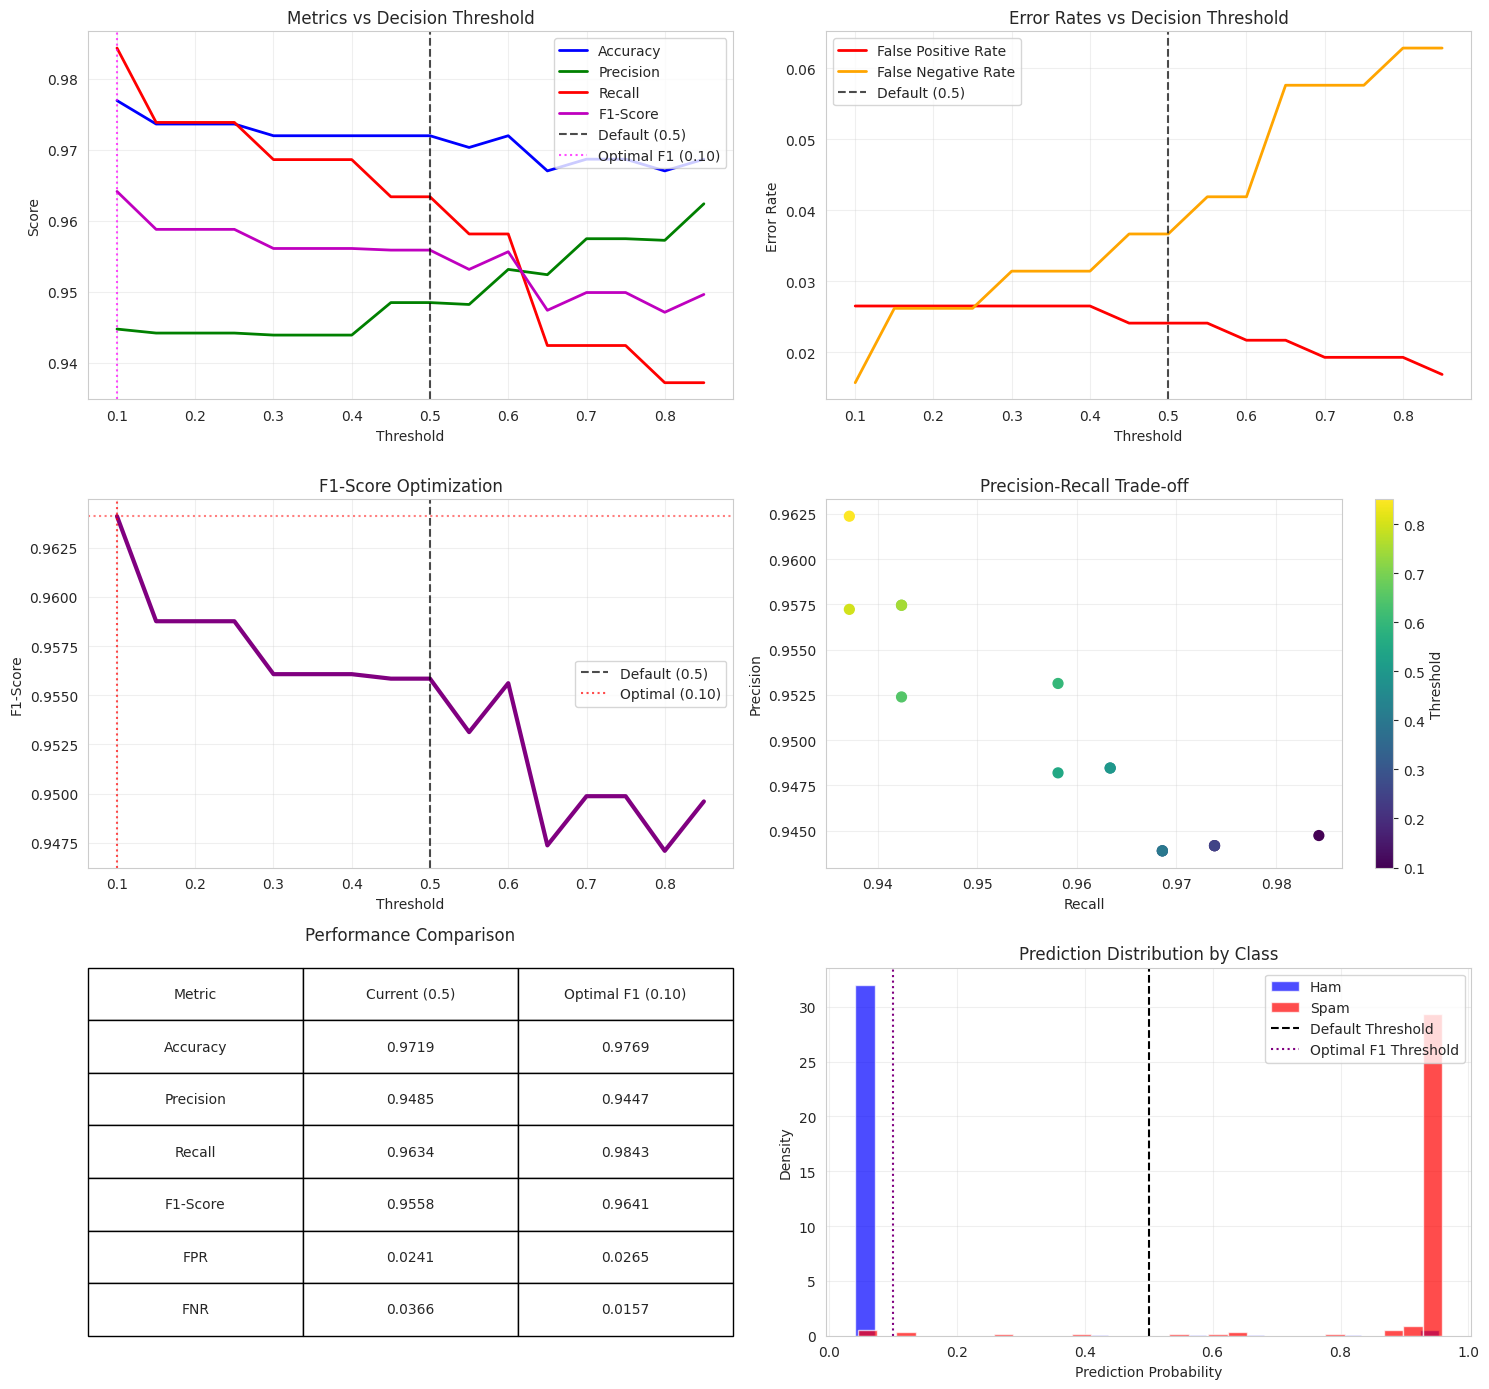

In [53]:
# Visualize threshold analysis
plt.figure(figsize=(15, 14))

# 1. Metrics vs Threshold
plt.subplot(3, 2, 1)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['Accuracy'], 'b-', label='Accuracy', linewidth=2)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['Precision'], 'g-', label='Precision', linewidth=2)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['Recall'], 'r-', label='Recall', linewidth=2)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['F1-Score'], 'm-', label='F1-Score', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default (0.5)')
plt.axvline(x=optimal_f1_threshold, color='magenta', linestyle=':', alpha=0.7, label=f'Optimal F1 ({optimal_f1_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Error Rates vs Threshold
plt.subplot(3, 2, 2)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['FPR'], 'r-', label='False Positive Rate', linewidth=2)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['FNR'], 'orange', label='False Negative Rate', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Decision Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. F1-Score Focus
plt.subplot(3, 2, 3)
plt.plot(threshold_analysis['Threshold'], threshold_analysis['F1-Score'], 'purple', linewidth=3)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default (0.5)')
plt.axvline(x=optimal_f1_threshold, color='red', linestyle=':', alpha=0.7, label=f'Optimal ({optimal_f1_threshold:.2f})')
plt.axhline(y=threshold_analysis['F1-Score'].max(), color='red', linestyle=':', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Optimization')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Trade-off
plt.subplot(3, 2, 4)
plt.scatter(threshold_analysis['Recall'], threshold_analysis['Precision'], 
           c=threshold_analysis['Threshold'], cmap='viridis', s=50)
plt.colorbar(label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')
plt.grid(True, alpha=0.3)

# 5. Performance Summary Table
plt.subplot(3, 2, 5)
plt.axis('off')
summary_data = [
    ['Metric', 'Current (0.5)', f'Optimal F1 ({optimal_f1_threshold:.2f})'],
    ['Accuracy', f"{metrics['accuracy']:.4f}", f"{opt_f1_row['Accuracy']:.4f}"],
    ['Precision', f"{metrics['precision']:.4f}", f"{opt_f1_row['Precision']:.4f}"],
    ['Recall', f"{metrics['recall']:.4f}", f"{opt_f1_row['Recall']:.4f}"],
    ['F1-Score', f"{metrics['f1_score']:.4f}", f"{opt_f1_row['F1-Score']:.4f}"],
    ['FPR', f"{metrics['fpr']:.4f}", f"{opt_f1_row['FPR']:.4f}"],
    ['FNR', f"{metrics['fnr']:.4f}", f"{opt_f1_row['FNR']:.4f}"]
]

table = plt.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Performance Comparison', pad=20)

# 6. Distribution of Predictions
plt.subplot(3, 2, 6)
plt.hist(y_pred_probs[y_true == 0], bins=30, alpha=0.7, label='Ham', color='blue', density=True)
plt.hist(y_pred_probs[y_true == 1], bins=30, alpha=0.7, label='Spam', color='red', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold')
plt.axvline(x=optimal_f1_threshold, color='purple', linestyle=':', label='Optimal F1 Threshold')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Prediction Distribution by Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# Final Performance Summary and Business Impact
print("📈 BERT Spam Detection Model - Final Performance Report")
print("=" * 70)

# Calculate business-relevant metrics
total_emails = len(y_true)
spam_emails = np.sum(y_true == 1)
ham_emails = np.sum(y_true == 0)

# Current performance
confusion = metrics_df.attrs['confusion_matrix']
tp = confusion['tp']
tn = confusion['tn']
fp = confusion['fp']
fn = confusion['fn']

print(f"\n📊 Dataset Summary:")
print(f"  Total emails tested: {total_emails:,}")
print(f"  Spam emails: {spam_emails:,} ({spam_emails/total_emails*100:.1f}%)")
print(f"  Ham emails: {ham_emails:,} ({ham_emails/total_emails*100:.1f}%)")

print(f"\n🎯 Model Performance (Threshold = 0.5):")
print(f"  ✅ Correctly identified spam: {tp:,} / {spam_emails:,} ({tp/spam_emails*100:.1f}%)")
print(f"  ✅ Correctly identified ham: {tn:,} / {ham_emails:,} ({tn/ham_emails*100:.1f}%)")
print(f"  ❌ Ham incorrectly flagged: {fp:,} / {ham_emails:,} ({fp/ham_emails*100:.2f}%)")
print(f"  ❌ Spam that passed through: {fn:,} / {spam_emails:,} ({fn/spam_emails*100:.1f}%)")

print(f"\n📋 Key Metrics Summary:")
print(f"  Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {metrics['precision']:.4f} (When model says 'spam', it's right {metrics['precision']*100:.1f}% of the time)")
print(f"  Recall: {metrics['recall']:.4f} (Catches {metrics['recall']*100:.1f}% of all spam)")
print(f"  F1-Score: {metrics['f1_score']:.4f} (Balanced performance measure)")
print(f"  AUC-ROC: {metrics['auc_roc']:.4f} (Excellent discrimination ability)")

print(f"\n🚨 Error Analysis:")
print(f"  False Positive Rate: {metrics['fpr']:.4f} ({metrics['fpr']*100:.2f}% of ham emails flagged)")
print(f"  False Negative Rate: {metrics['fnr']:.4f} ({metrics['fnr']*100:.1f}% of spam emails missed)")
print(f"  Ham Preservation Rate: {metrics['specificity']:.4f} ({metrics['specificity']*100:.2f}% of ham emails preserved)")

print(f"\n💼 Business Impact:")
if metrics['fpr'] < 0.01:
    fpr_assessment = "Excellent - Very few legitimate emails blocked"
elif metrics['fpr'] < 0.05:
    fpr_assessment = "Good - Acceptable level of legitimate emails blocked"
else:
    fpr_assessment = "Needs improvement - Too many legitimate emails blocked"

if metrics['fnr'] < 0.05:
    fnr_assessment = "Excellent - Very few spam emails pass through"
elif metrics['fnr'] < 0.10:
    fnr_assessment = "Good - Acceptable level of spam leakage"
else:
    fnr_assessment = "Needs improvement - Too much spam passes through"

print(f"  False Positive Impact: {fpr_assessment}")
print(f"  False Negative Impact: {fnr_assessment}")

print(f"\n🏆 Model Grade:")
if metrics['f1_score'] >= 0.90 and metrics['auc_roc'] >= 0.95:
    grade = "A+ (Excellent)"
elif metrics['f1_score'] >= 0.85 and metrics['auc_roc'] >= 0.90:
    grade = "A (Very Good)"
elif metrics['f1_score'] >= 0.80 and metrics['auc_roc'] >= 0.85:
    grade = "B+ (Good)"
elif metrics['f1_score'] >= 0.75 and metrics['auc_roc'] >= 0.80:
    grade = "B (Satisfactory)"
else:
    grade = "C (Needs Improvement)"

print(f"  Overall Performance: {grade}")
print(f"  Ready for Production: {'✅ Yes' if metrics['f1_score'] >= 0.80 and metrics['fpr'] <= 0.05 else '❌ Needs tuning'}")

print("=" * 70)

📈 BERT Spam Detection Model - Final Performance Report

📊 Dataset Summary:
  Total emails tested: 606
  Spam emails: 191 (31.5%)
  Ham emails: 415 (68.5%)

🎯 Model Performance (Threshold = 0.5):
  ✅ Correctly identified spam: 184 / 191 (96.3%)
  ✅ Correctly identified ham: 405 / 415 (97.6%)
  ❌ Ham incorrectly flagged: 10 / 415 (2.41%)
  ❌ Spam that passed through: 7 / 191 (3.7%)

📋 Key Metrics Summary:
  Accuracy: 0.9719 (97.19%)
  Precision: 0.9485 (When model says 'spam', it's right 94.8% of the time)
  Recall: 0.9634 (Catches 96.3% of all spam)
  F1-Score: 0.9558 (Balanced performance measure)
  AUC-ROC: 0.9896 (Excellent discrimination ability)

🚨 Error Analysis:
  False Positive Rate: 0.0241 (2.41% of ham emails flagged)
  False Negative Rate: 0.0366 (3.7% of spam emails missed)
  Ham Preservation Rate: 0.9759 (97.59% of ham emails preserved)

💼 Business Impact:
  False Positive Impact: Good - Acceptable level of legitimate emails blocked
  False Negative Impact: Excellent - Very